In [31]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchtext.data import get_tokenizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from time import time
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import pycountry
import itertools
import random
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import itertools
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline

tokenizer = get_tokenizer("basic_english")
lemmatizer = WordNetLemmatizer()
embedding_dim = 1000


In [6]:
# Define paths
path_to_data = "../challenge_data/"
path_to_training_tweets = os.path.join(path_to_data, "train_tweets")
path_to_eval_tweets = os.path.join(path_to_data, "eval_tweets")
output_path = "evaluation_predictions.csv"

## Load Data

In [7]:
# Load data
def load_data(path, verbose=False):
    li = []
    for filename in os.listdir(path):
        df = pd.read_csv(os.path.join(path, filename))
        li.append(df)
    output = pd.concat(li)
    if verbose:
        print(output.head())
        print(f'The shape of the data is: {output.shape}')
    return output

In [8]:
def concat_tweets(df, MAX_SUBGROUP=150, event_type=True):
    """
    For each group of tweets with the same ID/MatchID/PeriodID/EventType, 
    We create `MAX_SUBGROUP` subgroups of tweets by concatenating them.
    Therefore if `MAX_SUBGROUP` = 1, we have 1 tweet per ID/MatchID/PeriodID/EventType
    If `MAX_SUBGROUP` = +inf, we have all the tweets in different subgroups.
    """

    ### Grouping tweets who have same timestamp by concatenating them
    # Create an array of random integers in {0, ..., MAX_SUBGROUP} of size len(df_train)
    df["random_id"] = np.random.randint(0, MAX_SUBGROUP, len(df))
    if event_type:
        df_bis = df.groupby(['ID', "MatchID", "PeriodID", "EventType", "random_id"])['Tweet'].apply(lambda x: ' '.join(x)).reset_index().drop(columns='random_id')
    else:
        df_bis = df.groupby(['ID', "MatchID", "PeriodID", "random_id"])['Tweet'].apply(lambda x: ' '.join(x)).reset_index().drop(columns='random_id')
    df_bis = df_bis.sample(frac=1).reset_index(drop=True)
    return df_bis

# Preprocessing

In [9]:
# Extend the trigram list with full country names
list_of_countries_trigrams = [
    'AFG', 'RSA', 'ALB', 'ALG', 'GER', 'AND', 'ENG', 'ANG', 'AIA', 'ATG', 'KSA', 'ARG', 'ARM', 'ARU', 'AUS', 'AUT',
    'AZE', 'BAH', 'BHR', 'BAN', 'BRB', 'BEL', 'BLZ', 'BEN', 'BER', 'BHU', 'BLR', 'MYA', 'BOL', 'BIH', 'BOT', 'BRA',
    'BRU', 'BUL', 'BFA', 'BDI', 'CAM', 'CMR', 'CAN', 'CPV', 'CHI', 'CHN', 'CYP', 'COL', 'COM', 'CGO', 'PRK', 'KOR',
    'CRC', 'CIV', 'CRO', 'CUB', 'CUR', 'DEN', 'DJI', 'DMA', 'SCO', 'EGY', 'UAE', 'ECU', 'ERI', 'ESP', 'EST', 'ESW',
    'USA', 'ETH', 'FIJ', 'FIN', 'FRA', 'GAB', 'GAM', 'GEO', 'GHA', 'GIB', 'GRE', 'GRN', 'GUA', 'GUM', 'GUI', 'EQG',
    'GNB', 'GUY', 'HAI', 'HON', 'HKG', 'HUN', 'CAY', 'COK', 'FRO', 'SOL', 'TCA', 'VGB', 'VIR', 'IND', 'IDN', 'IRQ',
    'IRN', 'IRL', 'NIR', 'ISL', 'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KGZ', 'KVX', 'KUW', 'LAO', 'LES',
    'LVA', 'LBN', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MKD', 'MAD', 'MAS', 'MWI', 'MDV', 'MLI', 'MLT', 'MAR',
    'MRI', 'MTN', 'MEX', 'MDA', 'MNG', 'MNE', 'MSR', 'MOZ', 'NAM', 'NEP', 'NCA', 'NIG', 'NGA', 'NOR', 'NCL', 'NZL',
    'OMA', 'UGA', 'UZB', 'PAK', 'PLE', 'PAN', 'PNG', 'PAR', 'NED', 'WAL', 'PER', 'PHI', 'POL', 'PUR', 'POR', 'QAT',
    'COD', 'CTA', 'DOM', 'CZE', 'ROU', 'RUS', 'RWA', 'SKN', 'SMR', 'VIN', 'LCA', 'SLV', 'SAM', 'ASA', 'STP', 'SEN',
    'SRB', 'SEY', 'SLE', 'SIN', 'SVK', 'SVN', 'SOM', 'SDN', 'SSD', 'SRI', 'SWE', 'SUI', 'SUR', 'SYR', 'TJK', 'TAH',
    'TPE', 'TAN', 'CHA', 'THA', 'TLS', 'TOG', 'TGA', 'TRI', 'TUN', 'TKM', 'TUR', 'UKR', 'URU', 'VAN', 'VEN', 'VIE',
    'YEM', 'ZAM', 'ZIM', 'BOE', 'GUF', 'GBR', 'GLP', 'NMI', 'KIR', 'MTQ', 'NIU', 'REU', 'SMN', 'SMA', 'TUV', 'ZAN',
    'ALA', 'COR', 'GRL', 'GUE', 'IMA', 'FLK', 'MHL', 'JER', 'MYT', 'FSM', 'MCO', 'PLW', 'EUS', 'ESH', 'BLM', 'SPM',
    'SHN', 'VAT', 'WLF'
]

# Add full country names dynamically using pycountry
list_of_countries_full_names = english_countries = ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Congo (Democratic Republic)', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Ivory Coast', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Mauritania', 'Mauritius', 'Mexico', 'Federated States of Micronesia', 'Moldova', 'Monaco', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Myanmar (Burma)', 'Namibia', 'Nauru', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'North Korea', 'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia', 'Rwanda', 'St Kitts and Nevis', 'St Lucia', 'St Vincent', 'Samoa', 'San Marino', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia', 'South Africa', 'South Korea', 'South Sudan', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'Sweden', 'Switzerland', 'Syria', 'Tajikistan', 'Tanzania', 'Thailand', 'The Bahamas', 'The Gambia', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Tuvalu', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Vatican City', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe']


# Combine trigrams and full names into one list
list_of_countries_trigrams.extend(list_of_countries_full_names)
list_of_countries_trigrams = list(set(list_of_countries_trigrams))  # Remove duplicates

# Preload stopwords (ensure NLTK stopwords are downloaded)
stop_words = set(stopwords.words("english"))

stemmer = SnowballStemmer("english")
country_pattern = re.compile(r"\b(" + "|".join(map(re.escape, list_of_countries_trigrams)) + r")\b", re.IGNORECASE)

def preprocessing(df):
    # Compile regex patterns for efficiency
    url_pattern = re.compile(r"http[s]?://\S+|www\.\S+")
    mention_pattern = re.compile(r"@\w+")
    hashtag_pattern = re.compile(r"#\w+")
    number_pattern = re.compile(r"\d+")
    punctuation_pattern = re.compile(r"[^\w\s]")
    country_pattern = re.compile(r"\b(" + "|".join(map(re.escape, list_of_countries_trigrams)) + r")\b", re.IGNORECASE)
    rt_pattern = re.compile(r"rt")

    def clean_tweet(tweet):
        tweet = tweet.lower()  # Lowercase the text
        tweet = url_pattern.sub("", tweet)  # Remove URLs
        tweet = rt_pattern.sub("", tweet)  # Remove RT
        tweet = mention_pattern.sub("", tweet)  # Replace mentions with 'user'
        tweet = hashtag_pattern.sub("", tweet)  # Replace hashtags with 'hashtag'
        tweet = number_pattern.sub("", tweet)  # Replace numbers with 'number'
        tweet = country_pattern.sub("", tweet)  # Replace country trigrams with 'country'
        tweet = punctuation_pattern.sub("", tweet)  # Remove punctuation
        tweet = " ".join([word for word in tweet.split() if word not in stop_words])  # Remove stopwords
        return tweet
        # words = tweet.split()
        # words = [stemmer.stem(word) for word in words if word not in stop_words]  # Remove stopwords and apply stemming
        # return " ".join(words)

    # Apply cleaning to the "Tweet" column
    df["Tweet"] = df["Tweet"].apply(clean_tweet)
    return df

def glove_style_tokenize(tweet):
    # GloVe/Ruby-like tokenization patterns
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # Convert URLs to <URL>
    tweet = re.sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<URL>", tweet)

    # Separate slash words
    tweet = tweet.replace("/", " / ")

    # Convert @username to <USER>
    tweet = re.sub(r"@\w+", "<USER>", tweet)

    # Emoticons and faces
    tweet = re.sub(eyes + nose + r"[)d]+|[)d]+" + nose + eyes, "<SMILE>", tweet, flags=re.IGNORECASE)
    tweet = re.sub(eyes + nose + r"p+", "<LOLFACE>", tweet, flags=re.IGNORECASE)
    tweet = re.sub(eyes + nose + r"\(+|\)+" + nose + eyes, "<SADFACE>", tweet)
    tweet = re.sub(eyes + nose + r"[\/|l*]", "<NEUTRALFACE>", tweet)
    tweet = tweet.replace("<3", "<HEART>")

    # Numbers
    tweet = re.sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<NUMBER>", tweet)

    # Hashtags: split on camelCase or uppercase letters
    def hashtag_split(match):
        hashtag = match.group(0)
        hashtag_body = hashtag[1:]
        if hashtag_body.isupper():
            return "<HASHTAG> " + hashtag_body + " <ALLCAPS>"
        else:
            split_body = re.split(r'(?=[A-Z])', hashtag_body)
            split_body = [w for w in split_body if w]  # Remove empty
            return "<HASHTAG> " + " ".join(split_body)

    tweet = re.sub(r"#\S+", hashtag_split, tweet)

    # Repeated punctuation
    tweet = re.sub(r"([!?.]){2,}", r"\1 <REPEAT>", tweet)

    # Elongated words
    tweet = re.sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <ELONG>", tweet)

    # Allcaps words (2+ uppercase letters)
    def allcaps(match):
        word = match.group(0)
        return word.lower() + " <ALLCAPS>"

    tweet = re.sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps, tweet)

    return tweet

def preprocessing_glove(df):
    # Regex for your cleanup
    url_pattern = re.compile(r"http[s]?://\S+|www\.\S+")
    mention_pattern = re.compile(r"@\w+")
    hashtag_pattern = re.compile(r"#\w+")
    number_pattern = re.compile(r"\d+")
    punctuation_pattern = re.compile(r"[^\w\s]")
    rt_pattern = re.compile(r"\brt\b")

    def clean_tweet(tweet):
        # First apply GloVe-style tokenization
        tweet = glove_style_tokenize(tweet)

        # Convert to lowercase
        tweet = tweet.lower()

        # Remove RT
        tweet = rt_pattern.sub("", tweet)

        # Remove countries from your list
        tweet = country_pattern.sub("", tweet)

        # Additional cleanup (if desired):
        # Remove plain URLs (GloVe tags them as <URL>, so might keep <URL>)
        tweet = url_pattern.sub("", tweet)

        # Remove mentions (already replaced by <USER> but if you prefer to remove <USER> as well)
        tweet = tweet.replace("<USER>", "") 

        # Remove hashtags (already processed by GloVe step)
        tweet = hashtag_pattern.sub("", tweet)

        # Remove numbers (GloVe replaced them with <NUMBER>, decide if you keep or remove)
        tweet = tweet.replace("<NUMBER>", "")

        # Remove punctuation
        tweet = punctuation_pattern.sub("", tweet)

        # Tokenize into words
        words = tweet.split()

        # Remove stopwords
        words = [w for w in words if w not in stop_words]

        # Lemmatize words
        words = [lemmatizer.lemmatize(w) for w in words]

        return " ".join(words)

    df["Tweet"] = df["Tweet"].apply(clean_tweet)
    return df

## Create dictionary from tweets

In [10]:
def create_vocab(df, column_name, tokenizer, embedding_dim):
    words = []
    for text in df[column_name]:
        words.extend(tokenizer(text))
    vocab = dict(Counter(words).most_common(embedding_dim))
    return vocab, list(vocab.keys())

In [11]:
def plot_frequency(vocab, keywords, max_words = 40):
    top_keywords = keywords[:max_words]
    top_counts = [vocab[word] for word in top_keywords]

    plt.figure(figsize=(10, 5))
    plt.bar(top_keywords, top_counts)
    plt.xlabel('Keywords')
    plt.ylabel('Frequency')
    plt.title('Top 20 Keywords Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Embedding

In [44]:
def embedding(tweets, keywords=["football", "goal"]):
    feature_matrix = []
    for i, text in enumerate(tweets):
        tokens = tokenizer(text) # ex : 'Hello, I am a test' -> ['hello', 'i', 'am', 'a', 'test']
        token_counts = Counter(tokens)
        len_token = max(len(tokens), 1)
        frequencies = [token_counts.get(keyword, 0)/len_token for keyword in keywords]
        feature_matrix.append(frequencies)
    feature_matrix = np.array(feature_matrix)
    return feature_matrix 

def fit_tfidf_embedding(train_tweets, max_features=2000, ngram_range=(1,1), max_df=0.7, min_df=2, sublinear_tf=False):
    """
    Fit a TF-IDF vectorizer on the training tweets.
    Returns the fitted vectorizer.
    """
    vectorizer = TfidfVectorizer(max_features=max_features,
                                 max_df=max_df,
                                 ngram_range=ngram_range,
                                 min_df=min_df,
                                 sublinear_tf=sublinear_tf)
    vectorizer.fit(train_tweets)
    return vectorizer

def tfidf_embedding(tweets, vectorizer):
    """
    Transform tweets into TF-IDF features using a fitted vectorizer.
    """
    return vectorizer.transform(tweets).toarray()

def load_glove_embeddings(glove_file_path, embedding_dim=100):
    """
    Load GloVe embeddings from file into a dictionary: {word: vector}.
    """
    embeddings = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            if len(vector) == embedding_dim:
                embeddings[word] = vector
    return embeddings

def glove_embedding(tweets, embeddings, embedding_dim=100):
    """
    Convert each tweet to an average GloVe embedding.
    Words not found in embeddings are ignored.
    """
    feature_matrix = []
    for text in tweets:
        words = text.split()  # Already preprocessed
        word_vectors = [embeddings[w] for w in words if w in embeddings]
        if len(word_vectors) == 0:
            # If no known words, use a zero-vector
            avg_vector = np.zeros(embedding_dim, dtype=np.float32)
        else:
            avg_vector = np.mean(word_vectors, axis=0)
        feature_matrix.append(avg_vector)
    return np.array(feature_matrix)

def embedding_dim(train_tweets, vector_size=100, min_count=2, workers=4):
    # train_tweets is a list of tokenized tweets: [['hello', 'world'], ...]
    model = Word2Vec(train_tweets, vector_size=vector_size, min_count=min_count, workers=workers)
    return model

def word2vec_embedding(tweets, w2v_model):
    embedding_dim = w2v_model.vector_size
    feature_matrix = []
    for words in tweets:
        # words is a list of tokens
        word_vectors = [w2v_model.wv[w] for w in words if w in w2v_model.wv]
        if len(word_vectors) == 0:
            avg_vector = np.zeros(embedding_dim, dtype=np.float32)
        else:
            avg_vector = np.mean(word_vectors, axis=0)
        feature_matrix.append(avg_vector)
    return np.array(feature_matrix)

def embedding_dim(train_tweets, vector_size=100, min_count=2, workers=4):
    # train_tweets is a list of tokenized tweets: [['hello', 'world'], ...]
    model = Word2Vec(train_tweets, vector_size=vector_size, min_count=min_count, workers=workers)
    return model

def word2vec_embedding(tweets, w2v_model):
    embedding_dim = w2v_model.vector_size
    feature_matrix = []
    for words in tweets:
        # words is a list of tokens
        word_vectors = [w2v_model.wv[w] for w in words if w in w2v_model.wv]
        if len(word_vectors) == 0:
            avg_vector = np.zeros(embedding_dim, dtype=np.float32)
        else:
            avg_vector = np.mean(word_vectors, axis=0)
        feature_matrix.append(avg_vector)
    return np.array(feature_matrix)

# Training

In [13]:
def create_sets(train, test, train_X, test_X, batch_size = 64):
    # Scale the data
    scaler = StandardScaler()
    scaler.fit(train_X)
    train_X = scaler.transform(train_X)
    test_X = scaler.transform(test_X)

    # Labels
    train_y = np.array(train['EventType']).reshape(-1, 1).flatten()
    test_y = np.array(test['EventType']).reshape(-1, 1).flatten()
    train_y = torch.tensor(train_y, dtype=torch.float32).view(-1, 1)
    test_y = torch.tensor(test_y, dtype=torch.float32).view(-1, 1)

    trainset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), train_y)
    testset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), test_y)

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, scaler

def create_sets_for_eval(eval_X, scaler, batch_size = 64):
    # Scale the data
    eval_X = scaler.transform(eval_X)

    evalset = TensorDataset(torch.tensor(eval_X, dtype=torch.float32))

    eval_loader = DataLoader(evalset, batch_size=batch_size, shuffle=False)

    return eval_loader

In [14]:
class NNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropouts):
        super().__init__()
        assert len(hidden_dims) == len(dropouts)
        self.layers = nn.ModuleList()
        in_dim = input_dim
        for hidden_dim, dropout in zip(hidden_dims, dropouts):
            self.layers.append(nn.Linear(in_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim
        self.output_layer = nn.Linear(in_dim, output_dim)
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return torch.sigmoid(x)


In [15]:
def train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=10, scheduler=None, weight_1_0=0.5):
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    for epoch in range(num_epochs):
        # Scheduler
        if scheduler:
            scheduler.step()
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                predicted = (outputs > weight_1_0).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_accuracy = correct / total
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(test_loader))
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(test_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

    return history

In [16]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

# Overfitting of the dictionary

In [17]:
def intersection_keywords(keywords1, keywords2):
    return list(set(keywords1) & set(keywords2))

def proximity_keywords(keywords1, keywords2):
    return len(intersection_keywords(keywords1, keywords2))/max(len(keywords1), len(keywords2))

# Main code

In [220]:
# Load data
print("-"*50)
print("Loading data...")
t = time()

df_train = load_data(path_to_training_tweets)
df_eval = load_data(path_to_eval_tweets)

df_train = df_train.head(1000)
df_eval = df_eval.head(1000)

print(f"Data loaded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Preprocessing
print("Preprocessing...")
t = time()

df_train = preprocessing_glove(df_train)
df_eval = preprocessing_glove(df_eval)

print(f"Data preprocessed in {time()-t:.2f} seconds")
print("-"*50+"\n")


--------------------------------------------------
Loading data...
Data loaded in 6.74 seconds
--------------------------------------------------

Preprocessing...
Data preprocessed in 1.06 seconds
--------------------------------------------------



In [221]:
# Save df_train and df_eval
df_train.to_csv("df_train_glove.csv", index=False)
df_eval.to_csv("df_eval_glove.csv", index=False)

In [ ]:
# Groups_to_test = [10,100,1000,10000,100000,1000000]
# HISTORIES = []
# for MAX_SUBGROUP in Groups_to_test:
#     # Grouping 
#     print("Grouping tweets...")
#     t = time()

#     df_train_bis = concat_tweets(df_train, MAX_SUBGROUP=MAX_SUBGROUP)
#     df_eval_bis = concat_tweets(df_eval, MAX_SUBGROUP=MAX_SUBGROUP, event_type=False)

#     print(f"Tweets grouped in {time()-t:.2f} seconds")
#     print("-"*50+"\n")

#     # Splitting
#     print("Splitting data...")
#     t = time()

#     train, test = train_test_split(df_train_bis, test_size=0.3, random_state=42)

#     print(f"Data splitted in {time()-t:.2f} seconds")
#     print("-"*50+"\n")

#     # Creating the vocabulary
#     print("Creating the vocabulary...")
#     t = time()

#     vocab, keywords = create_vocab(pd.concat([train, test, df_eval_bis]), 'Tweet', tokenizer, embedding_dim)
#     vocab_eval, keywords_eval = create_vocab(df_eval_bis, 'Tweet', tokenizer, embedding_dim)

#     plot_frequency(vocab, keywords)
#     plot_frequency(vocab_eval, keywords_eval)

#     print(f'Proximity between keywords and keywords_eval: {proximity_keywords(keywords, keywords_eval)*100:.2f}%')
#     print(f"Vocabulary created in {time()-t:.2f} seconds")
#     print("-"*50+"\n")

#     # Embedding
#     print("Embedding...")
#     t = time()

#     train_X = embedding(train['Tweet'], keywords=keywords)
#     test_X = embedding(test['Tweet'], keywords=keywords)
#     eval_X = embedding(df_eval_bis['Tweet'], keywords=keywords)

#     print(f"Data embedded in {time()-t:.2f} seconds")
#     print("-"*50+"\n")

#     # Creating the datasets
#     print("Creating the datasets...")
#     t = time()

#     train_loader, test_loader = create_sets(train, test, train_X, test_X)

#     print(f"Datasets created in {time()-t:.2f} seconds")
#     print("-"*50+"\n")

#     # Model
#     model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     model.to(device)

#     # Loss and optimizer
#     criterion = nn.BCELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

#     # Training
#     print("Training the model...")
#     t = time()

#     HISTORIES.append(train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=15))

#     print(f"Model trained in {time()-t:.2f} seconds")
#     print("-"*50+"\n")



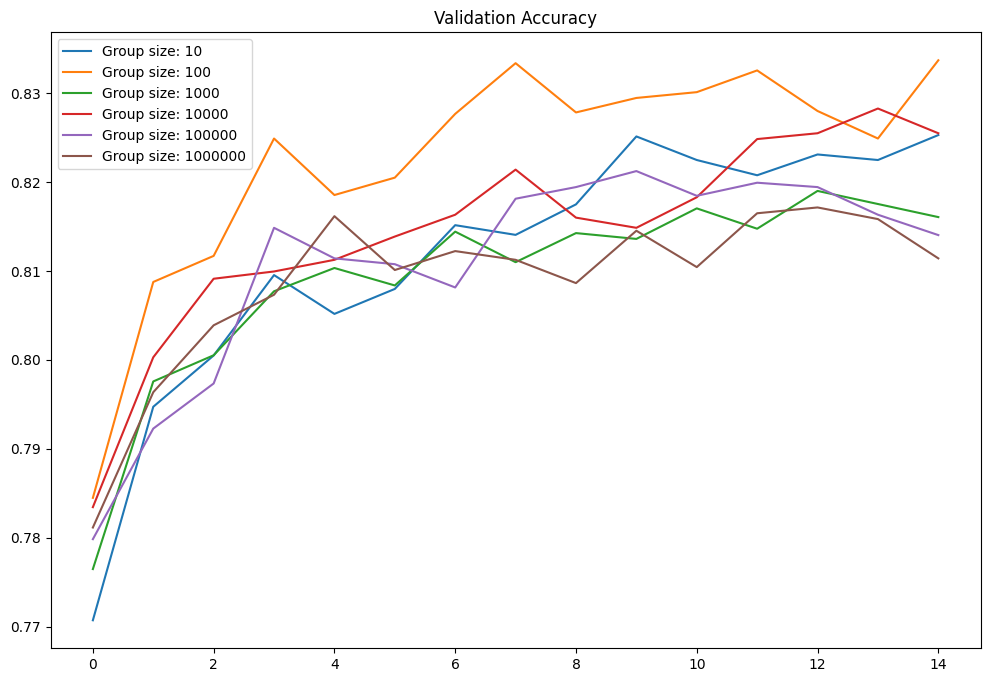

In [ ]:
# def plot_histories(histories, groups):
#     plt.figure(figsize=(12, 8))
#     for i, history in enumerate(histories):
#         plt.plot(history['val_accuracy'], label=f'Group size: {groups[i]}')
#     plt.legend()
#     plt.title('Validation Accuracy')
#     plt.show()

# plot_histories(HISTORIES, Groups_to_test)

# Grid search on TF-IDF

In [2]:
# Import the preprocessed data
df_train = pd.read_csv("df_train_withoutstemming.csv")
df_eval = pd.read_csv("df_eval_withoutstemming.csv")

In [3]:

# str the 'Tweet' column
df_train['Tweet'] = df_train['Tweet'].astype(str)
df_eval['Tweet'] = df_eval['Tweet'].astype(str)

In [18]:
Group_train = 10
Group_eval = 10

# Grouping 
print("Grouping tweets...")
t = time()

df_train_bis = concat_tweets(df_train, MAX_SUBGROUP=Group_train, event_type=True)
df_eval_bis = concat_tweets(df_eval, MAX_SUBGROUP=Group_eval, event_type=False)

print(f"Tweets grouped in {time()-t:.2f} seconds")
print("-"*50+"\n")

Grouping tweets...
Tweets grouped in 1.65 seconds
--------------------------------------------------



In [21]:
print(len(df_train_bis))

21370


In [26]:
# Suppose you have your data in df with a 'Tweet' column and labels in 'EventType'
X = df_train_bis['Tweet']
y = df_train_bis['EventType']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a pipeline that first vectorizes with TF-IDF, then trains a classifier
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Parameter grid for TF-IDF and the classifier
param_grid = {
    'tfidf__max_features': [1000, 2000],
    'tfidf__ngram_range': [(1,1), (1,2)],  # Unigrams vs unigrams+bigrams
    'tfidf__min_df': [2, 5],
    'tfidf__max_df': [0.7, 0.9],
    'tfidf__sublinear_tf': [True, False],
    'clf__C': [0.1, 1],  # Regularization strength for LogisticRegression
}

# Grid search
grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on the validation set
best_model = grid_search.best_estimator_
val_score = best_model.score(X_val, y_val)
print("Validation score:", val_score)

Best parameters: {'clf__C': 1, 'tfidf__max_df': 0.7, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__sublinear_tf': False}
Best cross-validation score: 0.7836924358243889
Validation score: 0.7912962096396818


# Quickly verify the best best classifier

LogisticRegression, SVC, RandomForestClassifier, XGBClassifier

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=2000,
        max_df=0.7,
        ngram_range=(1,1),
        min_df=2,
        sublinear_tf=False
    )),
    # Try Logistic Regression
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
print("LR Accuracy:", pipeline.score(X_val, y_val))

# Replace the classifier with an SVM
pipeline.set_params(clf=SVC())
pipeline.fit(X_train, y_train)
print("SVC Accuracy:", pipeline.score(X_val, y_val))

# Try Random Forest
pipeline.set_params(clf=RandomForestClassifier())
pipeline.fit(X_train, y_train)
print("RF Accuracy:", pipeline.score(X_val, y_val))

# Try XGBoost
pipeline.set_params(clf=XGBClassifier(eval_metric='logloss'))
pipeline.fit(X_train, y_train)
print("XGB Accuracy:", pipeline.score(X_val, y_val))

LR Accuracy: 0.7912962096396818
SVC Accuracy: 0.842536265793168
RF Accuracy: 0.7868507253158633


/users/eleves-b/2022/axel.delaval/miniconda3/envs/inf554bis/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:36:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB Accuracy: 0.8072063640617688


Simple FeedForward NN

In [39]:
# Fit on training data
vectorizer = fit_tfidf_embedding(X_train, max_features=2000)

# Transform data
train_X = tfidf_embedding(X_train, vectorizer)
test_X = tfidf_embedding(X_val, vectorizer)

# Create datasets 
train_y = np.array(y_train).reshape(-1, 1).flatten()
test_y = np.array(y_val).reshape(-1, 1).flatten()
train_y = torch.tensor(train_y, dtype=torch.float32).view(-1, 1)
test_y = torch.tensor(test_y, dtype=torch.float32).view(-1, 1)

trainset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), train_y)
testset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), test_y)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

model = SimpleMLP(input_dim=train_X.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    accuracy = correct / total

print("MLP Accuracy:", accuracy)

MLP Accuracy: 0.796911558259242


In [41]:
from torch.nn.utils.rnn import pad_sequence

# Create vocab
vocab, keywords = create_vocab(pd.concat([X_train, X_val, df_eval_bis]), 'Tweet', tokenizer, 100)
# Create sequences
train_sequences = [torch.tensor(embedding(tweet, keywords=keywords), dtype=torch.float32) for tweet in X_train]


train_sequences_tensors = [torch.tensor(seq, dtype=torch.long) for seq in train_sequences]
train_sequences_padded = pad_sequence(train_sequences_tensors, batch_first=True, padding_value=0)
train_labels_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

train_dataset = torch.utils.data.TensorDataset(train_sequences_padded, train_labels_torch)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        # LSTM output: (batch, seq_len, hidden_dim)
        out, (h, c) = self.lstm(embedded)
        # h is last hidden state: (1, batch, hidden_dim)
        h = h.squeeze(0)
        out = self.fc(h)
        out = self.sigmoid(out)
        return out

model = LSTMClassifier(vocab_size=len(vocab), embed_dim=100, hidden_dim=128)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    accuracy = correct / total

print("LSTM Accuracy:", accuracy)

KeyboardInterrupt: 

# Test on separate match

In [60]:
# Import the preprocessed data
df_train = pd.read_csv("df_train_withoutstemming.csv")
df_eval = pd.read_csv("df_eval_withoutstemming.csv")

# str the 'Tweet' column
df_train['Tweet'] = df_train['Tweet'].astype(str)
df_eval['Tweet'] = df_eval['Tweet'].astype(str)

Group_train = 10
Group_eval = 10

# Grouping 
print("Grouping tweets...")
t = time()

df_train_bis = concat_tweets(df_train, MAX_SUBGROUP=Group_train, event_type=True)
df_eval_bis = concat_tweets(df_eval, MAX_SUBGROUP=Group_eval, event_type=False)

print(f"Tweets grouped in {time()-t:.2f} seconds")
print("-"*50+"\n")

Grouping tweets...
Tweets grouped in 1.85 seconds
--------------------------------------------------



In [61]:
match3 = df_train_bis[df_train_bis['MatchID'] == 3]
matchelse = df_train_bis[df_train_bis['MatchID'] != 3]

In [62]:
# Hyperparameters
output_dim = 1
embedding_dim = 2000
input_dim = embedding_dim
weight_1_0 = 0.55
hidden_dims = [embedding_dim*3,embedding_dim//20, embedding_dim//10]
dropouts = [0.95] * len(hidden_dims)
epochs = 20
lr = 0.001
decay = 1e-5


# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(matchelse, test_size=0.3, random_state=42)


print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# # Creating the vocabulary
# print("Creating the vocabulary...")
# t = time()

# vocab, keywords = create_vocab(pd.concat([train, test, match3]), 'Tweet', tokenizer, embedding_dim)
# vocab_eval, keywords_eval = create_vocab(match3, 'Tweet', tokenizer, embedding_dim)

# plot_frequency(vocab, keywords)
# plot_frequency(vocab_eval, keywords_eval)

# print(f'Proximity between keywords and keywords_eval: {proximity_keywords(keywords, keywords_eval)*100:.2f}%')
# print(f"Vocabulary created in {time()-t:.2f} seconds")
# print("-"*50+"\n")

# Embedding
# print("Embedding...")
# t = time()

# train_tokens = [tweet.split() for tweet in train['Tweet']]
# model_w2v = train_word2vec_model(train_tokens, vector_size=embedding_dim)

# train_tokens = [t.split() for t in train['Tweet']]
# test_tokens = [t.split() for t in test['Tweet']]
# eval_tokens = [t.split() for t in df_eval['Tweet']]

# train_X = word2vec_embedding(train_tokens, model_w2v)
# test_X = word2vec_embedding(test_tokens, model_w2v)
# eval_X = word2vec_embedding(eval_tokens, model_w2v)

# # Load GloVe
# embeddings = load_glove_embeddings("../Glove/glove.twitter.27B.200d.txt", embedding_dim=embedding_dim)

# # Convert tweets
# train_X = glove_embedding(train['Tweet'], embeddings, embedding_dim=embedding_dim)
# test_X = glove_embedding(test['Tweet'], embeddings, embedding_dim=embedding_dim)
# eval_X = glove_embedding(df_eval['Tweet'], embeddings, embedding_dim=embedding_dim)

# Fit on training data
vectorizer = fit_tfidf_embedding(train['Tweet'], max_features=embedding_dim)

# Transform data
train_X = tfidf_embedding(train['Tweet'], vectorizer)
test_X = tfidf_embedding(test['Tweet'], vectorizer)
eval_X = tfidf_embedding(df_eval['Tweet'], vectorizer)

# train_X = embedding(train['Tweet'], keywords=keywords)
# test_X = embedding(test['Tweet'], keywords=keywords)
# eval_X = embedding(match3['Tweet'], keywords=keywords)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader, scaler = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
scheduler = None

# Training
print("Training the model...")
t = time()

print(train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=epochs, weight_1_0=weight_1_0, scheduler=scheduler))

print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Also test on different models (SVM, LG, RF, XGB)
# Regularized SVM
print("Testing on SVM with regularization:")
t = time()
svm = SVC(C=0.1, kernel='linear')  # Smaller C increases regularization
svm.fit(train_X, train['EventType'])
print("SVM Accuracy:", svm.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

# Regularized Logistic Regression
print("Testing on Logistic Regression with regularization:")
t = time()
lg = LogisticRegression(max_iter=1000, C=0.1, penalty='l2', solver='liblinear')  # Stronger L2 regularization
lg.fit(train_X, train['EventType'])
print("Logistic Regression Accuracy:", lg.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

# Regularized Random Forest
print("Testing on Random Forest with regularization:")
t = time()
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=3)  # Depth/leaf regularization
rf.fit(train_X, train['EventType'])
print("Random Forest Accuracy:", rf.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

# Regularized XGBoost
print("Testing on XGBoost with regularization:")
t = time()
xgb = XGBClassifier(eval_metric='logloss', reg_alpha=1, reg_lambda=1, max_depth=6, learning_rate=0.05, n_estimators=200)
xgb.fit(train_X, train['EventType'])
print("XGBoost Accuracy:", xgb.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

Splitting data...
Data splitted in 0.00 seconds
--------------------------------------------------

Data embedded in 24.50 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 0.33 seconds
--------------------------------------------------

Training the model...
Epoch 1/20, Train Loss: 0.8694, Val Loss: 0.6858, Val Accuracy: 0.4559
Epoch 2/20, Train Loss: 0.7037, Val Loss: 0.6859, Val Accuracy: 0.5184
Epoch 3/20, Train Loss: 0.7004, Val Loss: 0.6862, Val Accuracy: 0.5933
Epoch 4/20, Train Loss: 0.6952, Val Loss: 0.6842, Val Accuracy: 0.5976
Epoch 5/20, Train Loss: 0.6956, Val Loss: 0.6820, Val Accuracy: 0.6200
Epoch 6/20, Train Loss: 0.6916, Val Loss: 0.6759, Val Accuracy: 0.6271
Epoch 7/20, Train Loss: 0.6882, Val Loss: 0.6738, Val Accuracy: 0.6188
Epoch 8/20, Train Loss: 0.6826, Val Loss: 0.6712, Val Accuracy: 0.6215
Epoch 9/20, Train Loss: 0.6757, Val Loss: 0.6657, Val Accuracy: 0.6235
Epoch 10/20, Train Loss: 0.6680, Val Loss: 0.6

Majority vote accuracy: 0.6923076923076923
NN Accuracy: 0.7769230769230769
LG Accuracy: 0.6307692307692307
SVM Accuracy: 0.6692307692307692
RF Accuracy: 0.6307692307692307
XGB Accuracy: 0.8076923076923077


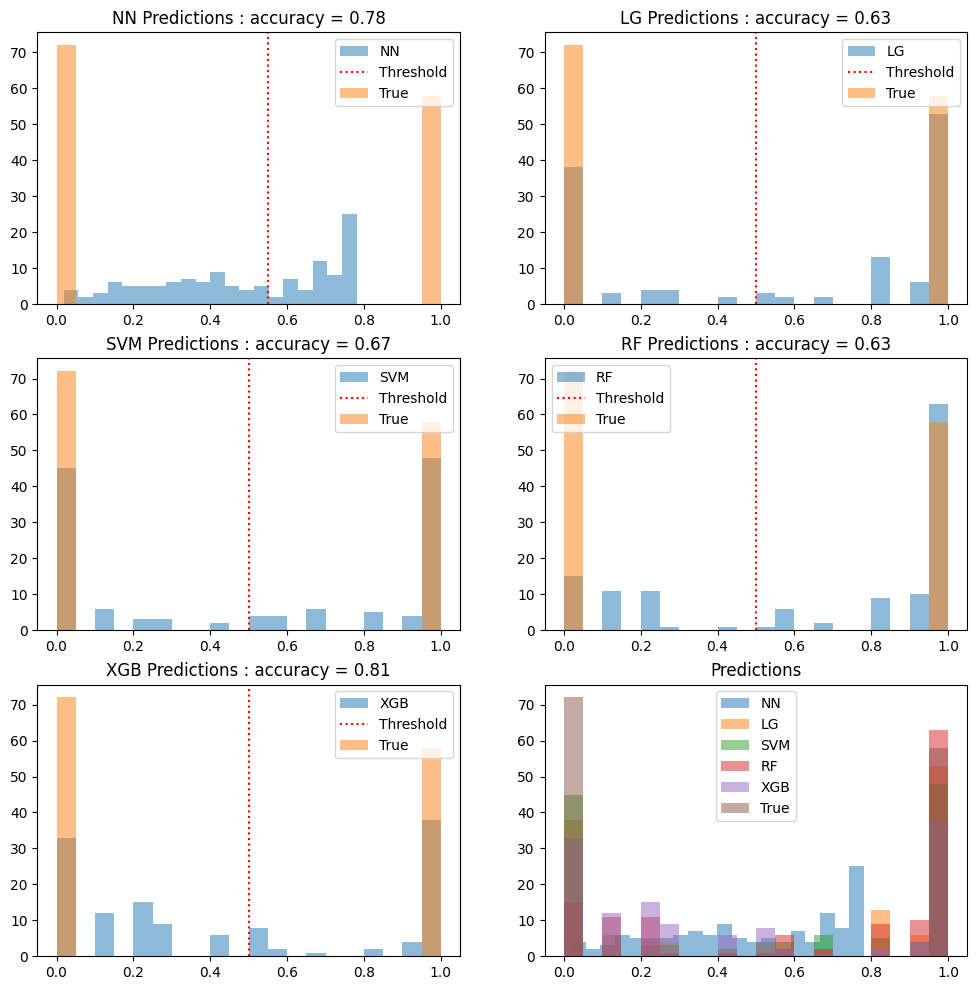

In [63]:
# Instead of passing eval_X, pass match3's tweets to the model
match3_tweets = match3['Tweet']
match3_X = tfidf_embedding(match3_tweets, vectorizer)
# match3_X = glove_embedding(match3_tweets, embeddings, embedding_dim=embedding_dim)
# match3_X = word2vec_embedding([t.split() for t in match3_tweets], model_w2v)
match3_loader = create_sets_for_eval(match3_X, scaler)

predictions_NN = []
model.eval()
with torch.no_grad():
    for batch in match3_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        predictions_NN.extend(outputs.cpu().numpy().flatten())

pridictions_lg = lg.predict(match3_X)
pridictions_svm = svm.predict(match3_X)
pridictions_rf = rf.predict(match3_X)
pridictions_xgb = xgb.predict(match3_X)

# Now predictions should align with match3 rows
predictions_match3 = pd.DataFrame({
    'ID': match3['ID'],
    'Predicted_NN': predictions_NN,
    'Predicted_LG': pridictions_lg,
    'Predicted_SVM': pridictions_svm,
    'Predicted_RF': pridictions_rf,
    'Predicted_XGB': pridictions_xgb,
    'MatchID': match3['MatchID'],
    'PeriodID': match3['PeriodID'],
    'EventType': match3['EventType']
})

# Group by ID/PeriodID/MatchID/EventType and average the predictions and sort by PeriodID
predictions_match3 = predictions_match3.groupby(['ID', 'PeriodID', 'MatchID', 'EventType']).mean().reset_index().sort_values('PeriodID')
predictions_match3['Predicted_NN_three'] = (predictions_match3['Predicted_NN'] > weight_1_0).astype(int)
predictions_match3['Predicted_LG_three'] = (predictions_match3['Predicted_LG'] > 0.5).astype(int)
predictions_match3['Predicted_SVM_three'] = (predictions_match3['Predicted_SVM'] > 0.5).astype(int)
predictions_match3['Predicted_RF_three'] = (predictions_match3['Predicted_RF'] > 0.5).astype(int)
predictions_match3['Predicted_XGB_three'] = (predictions_match3['Predicted_XGB'] > 0.5).astype(int)

# Accuracy if taking the majority vote between all models
print("Majority vote accuracy:", (predictions_match3[['Predicted_NN_three', 'Predicted_LG_three', 'Predicted_SVM_three', 'Predicted_RF_three', 'Predicted_XGB_three']].mode(axis=1)[0] == predictions_match3['EventType']).mean())

# Save the predictions
predictions_match3.to_csv('match3.csv', index=False)

# Compute the accuracies
print("NN Accuracy:", (predictions_match3['Predicted_NN_three'] == predictions_match3['EventType']).mean())
print("LG Accuracy:", (predictions_match3['Predicted_LG_three'] == predictions_match3['EventType']).mean())
print("SVM Accuracy:", (predictions_match3['Predicted_SVM_three'] == predictions_match3['EventType']).mean())
print("RF Accuracy:", (predictions_match3['Predicted_RF_three'] == predictions_match3['EventType']).mean())
print("XGB Accuracy:", (predictions_match3['Predicted_XGB_three'] == predictions_match3['EventType']).mean())

# Histogram of the predictions and the true values, with a dot-line at weight_1_0
# Each model's predictions are shown in a different subplot with the true values and the threshold

plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.hist(predictions_match3['Predicted_NN'], bins=20, alpha=0.5, label='NN')
plt.axvline(weight_1_0, color='r', linestyle='dotted', label='Threshold')
plt.hist(predictions_match3['EventType'], bins=20, alpha=0.5, label='True')
plt.legend()
plt.title(f'NN Predictions : accuracy = {accuracy_score(predictions_match3["EventType"], predictions_match3["Predicted_NN_three"]):.2f}')

plt.subplot(3, 2, 2)
plt.hist(predictions_match3['Predicted_LG'], bins=20, alpha=0.5, label='LG')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.hist(predictions_match3['EventType'], bins=20, alpha=0.5, label='True')
plt.legend()
plt.title(f'LG Predictions : accuracy = {accuracy_score(predictions_match3["EventType"], predictions_match3["Predicted_LG_three"]):.2f}')

plt.subplot(3, 2, 3)
plt.hist(predictions_match3['Predicted_SVM'], bins=20, alpha=0.5, label='SVM')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.hist(predictions_match3['EventType'], bins=20, alpha=0.5, label='True')
plt.legend()
plt.title(f'SVM Predictions : accuracy = {accuracy_score(predictions_match3["EventType"], predictions_match3["Predicted_SVM_three"]):.2f}')

plt.subplot(3, 2, 4)
plt.hist(predictions_match3['Predicted_RF'], bins=20, alpha=0.5, label='RF')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.hist(predictions_match3['EventType'], bins=20, alpha=0.5, label='True')
plt.legend()
plt.title(f'RF Predictions : accuracy = {accuracy_score(predictions_match3["EventType"], predictions_match3["Predicted_RF_three"]):.2f}')

plt.subplot(3, 2, 5)
plt.hist(predictions_match3['Predicted_XGB'], bins=20, alpha=0.5, label='XGB')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.hist(predictions_match3['EventType'], bins=20, alpha=0.5, label='True')
plt.legend()
plt.title(f'XGB Predictions : accuracy = {accuracy_score(predictions_match3["EventType"], predictions_match3["Predicted_XGB_three"]):.2f}')

# Last subplot with the three models' predictions
plt.subplot(3, 2, 6)
plt.hist(predictions_match3['Predicted_NN'], bins=20, alpha=0.5, label='NN')
plt.hist(predictions_match3['Predicted_LG'], bins=20, alpha=0.5, label='LG')
plt.hist(predictions_match3['Predicted_SVM'], bins=20, alpha=0.5, label='SVM')
plt.hist(predictions_match3['Predicted_RF'], bins=20, alpha=0.5, label='RF')
plt.hist(predictions_match3['Predicted_XGB'], bins=20, alpha=0.5, label='XGB')
plt.hist(predictions_match3['EventType'], bins=20, alpha=0.5, label='True')
plt.legend()
plt.title(f'Predictions')

plt.show()


Now Train the model on the whole dataset

In [64]:
df_train = pd.read_csv("df_train_withoutstemming.csv")
df_eval = pd.read_csv("df_eval_withoutstemming.csv")

df_train['Tweet'] = df_train['Tweet'].astype(str)
df_eval['Tweet'] = df_eval['Tweet'].astype(str)

# Grouping
print("Grouping tweets...")
t = time()

df_train_bis = concat_tweets(df_train, MAX_SUBGROUP=Group_train, event_type=True)
df_eval_bis = concat_tweets(df_eval, MAX_SUBGROUP=Group_eval, event_type=False)

print(f"Tweets grouped in {time()-t:.2f} seconds")
print("-"*50+"\n")

Grouping tweets...
Tweets grouped in 1.60 seconds
--------------------------------------------------



In [65]:
# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train_bis, test_size=0.01, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# # Creating the vocabulary
# print("Creating the vocabulary...")
# t = time()

# vocab, keywords = create_vocab(pd.concat([train, test, df_eval_bis]), 'Tweet', tokenizer, embedding_dim)
# vocab_eval, keywords_eval = create_vocab(df_eval_bis, 'Tweet', tokenizer, embedding_dim)

# plot_frequency(vocab, keywords)
# plot_frequency(vocab_eval, keywords_eval)

# print(f'Proximity between keywords and keywords_eval: {proximity_keywords(keywords, keywords_eval)*100:.2f}%')
# print(f"Vocabulary created in {time()-t:.2f} seconds")
# print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

# train_tokens = [tweet.split() for tweet in train['Tweet']]
# model_w2v = train_word2vec_model(train_tokens, vector_size=embedding_dim)

# train_tokens = [t.split() for t in train['Tweet']]
# test_tokens = [t.split() for t in test['Tweet']]
# eval_tokens = [t.split() for t in df_eval['Tweet']]

# train_X = word2vec_embedding(train_tokens, model_w2v)
# test_X = word2vec_embedding(test_tokens, model_w2v)
# eval_X = word2vec_embedding(eval_tokens, model_w2v)

# # Convert tweets
# train_X = glove_embedding(train['Tweet'], embeddings, embedding_dim=embedding_dim)
# test_X = glove_embedding(test['Tweet'], embeddings, embedding_dim=embedding_dim)
# eval_X = glove_embedding(df_eval['Tweet'], embeddings, embedding_dim=embedding_dim)

# Fit on training data
vectorizer = fit_tfidf_embedding(train['Tweet'], max_features=embedding_dim)

# Transform data
train_X = tfidf_embedding(train['Tweet'], vectorizer)
test_X = tfidf_embedding(test['Tweet'], vectorizer)
eval_X = tfidf_embedding(df_eval['Tweet'], vectorizer)

# train_X = embedding(train['Tweet'], keywords=keywords)
# test_X = embedding(test['Tweet'], keywords=keywords)
# eval_X = embedding(df_eval_bis['Tweet'], keywords=keywords)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader, scaler = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

# Training
print("Training the model...")
t = time()

print(train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=epochs, weight_1_0=weight_1_0, scheduler=scheduler))

print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Also test on different models (SVM, LG, RF, XGB)
# Regularized SVM
print("Testing on SVM with regularization:")
t = time()
svm = SVC(C=0.1, kernel='linear')  # Smaller C increases regularization
svm.fit(train_X, train['EventType'])
print("SVM Accuracy:", svm.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

# Regularized Logistic Regression
print("Testing on Logistic Regression with regularization:")
t = time()
lg = LogisticRegression(max_iter=1000, C=0.1, penalty='l2', solver='liblinear')  # Stronger L2 regularization
lg.fit(train_X, train['EventType'])
print("Logistic Regression Accuracy:", lg.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

# Regularized Random Forest
print("Testing on Random Forest with regularization:")
t = time()
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=3)  # Depth/leaf regularization
rf.fit(train_X, train['EventType'])
print("Random Forest Accuracy:", rf.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

# Regularized XGBoost
print("Testing on XGBoost with regularization:")
t = time()
xgb = XGBClassifier(eval_metric='logloss', reg_alpha=1, reg_lambda=1, max_depth=6, learning_rate=0.05, n_estimators=200)
xgb.fit(train_X, train['EventType'])
print("XGBoost Accuracy:", xgb.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

Splitting data...
Data splitted in 0.00 seconds
--------------------------------------------------

Embedding...
Data embedded in 28.70 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 0.39 seconds
--------------------------------------------------

Training the model...
Epoch 1/20, Train Loss: 0.8010, Val Loss: 0.6826, Val Accuracy: 0.4486
Epoch 2/20, Train Loss: 0.6997, Val Loss: 0.6773, Val Accuracy: 0.5748
Epoch 3/20, Train Loss: 0.6983, Val Loss: 0.6745, Val Accuracy: 0.5888
Epoch 4/20, Train Loss: 0.6934, Val Loss: 0.6726, Val Accuracy: 0.5888
Epoch 5/20, Train Loss: 0.6861, Val Loss: 0.6603, Val Accuracy: 0.6168
Epoch 6/20, Train Loss: 0.6762, Val Loss: 0.6397, Val Accuracy: 0.6215
Epoch 7/20, Train Loss: 0.6604, Val Loss: 0.6081, Val Accuracy: 0.6916
Epoch 8/20, Train Loss: 0.6447, Val Loss: 0.5717, Val Accuracy: 0.7196
Epoch 9/20, Train Loss: 0.6230, Val Loss: 0.5339, Val Accuracy: 0.7710
Epoch 10/20, Train Loss: 0.6052, 

Predictions saved to 'evaluation_predictions.csv' and individual model files.
--------------------------------------------------



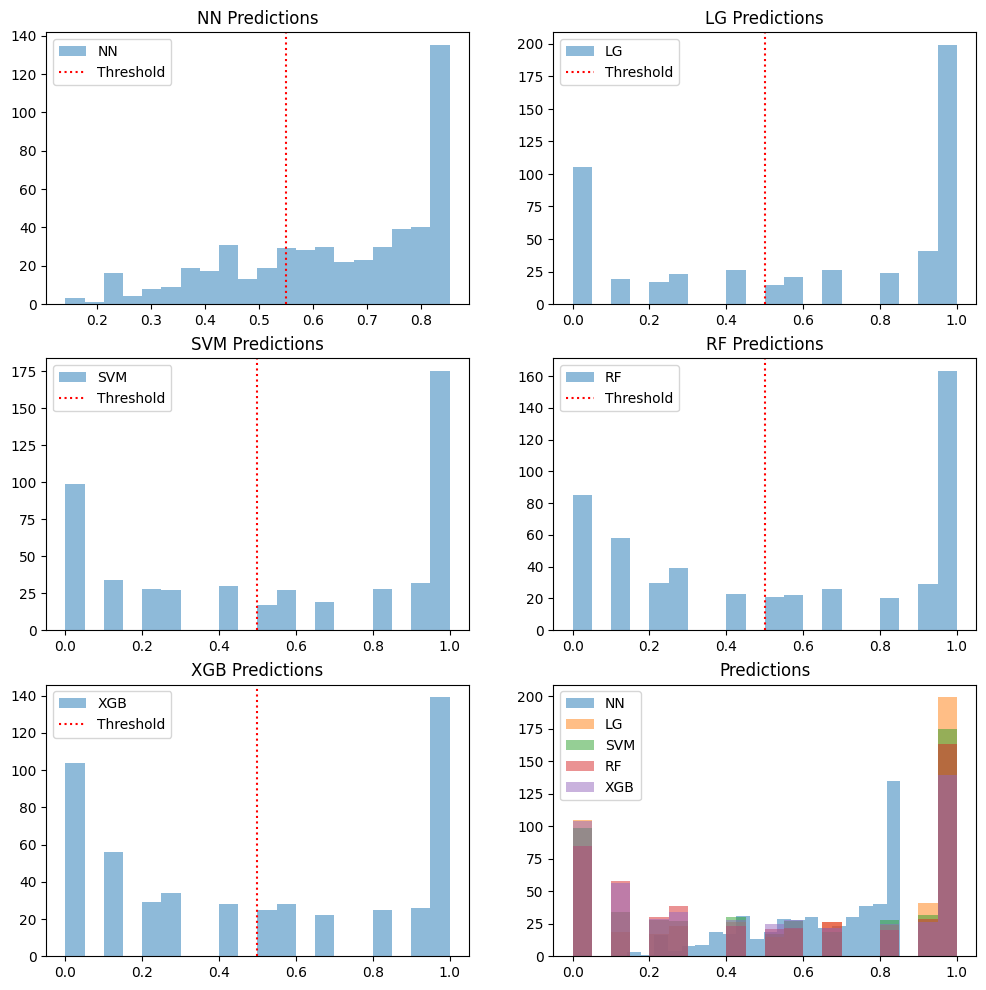

In [66]:
# Instead of passing eval_X, pass match3's tweets to the model
eval_tweets = df_eval_bis['Tweet']
eval_X = tfidf_embedding(eval_tweets, vectorizer)
# eval_X = glove_embedding(eval_tweets, embeddings, embedding_dim=embedding_dim)
# eval_X = word2vec_embedding([t.split() for t in eval_tweets], model_w2v)
eval_loader = create_sets_for_eval(eval_X, scaler)

predictions_NN = []
model.eval()
with torch.no_grad():
    for batch in eval_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        predictions_NN.extend(outputs.cpu().numpy().flatten())

pridictions_lg = lg.predict(eval_X)
pridictions_svm = svm.predict(eval_X)
pridictions_rf = rf.predict(eval_X)
pridictions_xgb = xgb.predict(eval_X)

# Now predictions should align with match3 rows
predictions_eval = pd.DataFrame({
    'ID': df_eval_bis['ID'],
    'MatchID': df_eval_bis['MatchID'],
    'PeriodID': df_eval_bis['PeriodID'],
    'Predicted_NN': predictions_NN,
    'Predicted_LG': pridictions_lg,
    'Predicted_SVM': pridictions_svm,
    'Predicted_RF': pridictions_rf,
    'Predicted_XGB': pridictions_xgb
})


# Group by ID/PeriodID/MatchID and average the predictions and sort by matchID and then PeriodID
predictions_eval = predictions_eval.groupby(['ID', 'MatchID', 'PeriodID']).mean().reset_index().sort_values(['MatchID', 'PeriodID'])
predictions_eval['Predicted_NN_three'] = (predictions_eval['Predicted_NN'] > weight_1_0).astype(int)
predictions_eval['Predicted_LG_three'] = (predictions_eval['Predicted_LG'] > 0.5).astype(int)
predictions_eval['Predicted_SVM_three'] = (predictions_eval['Predicted_SVM'] > 0.5).astype(int)
predictions_eval['Predicted_RF_three'] = (predictions_eval['Predicted_RF'] > 0.5).astype(int)
predictions_eval['Predicted_XGB_three'] = (predictions_eval['Predicted_XGB'] > 0.5).astype(int)

# Histogram of the predictions and the true values as before 
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.hist(predictions_eval['Predicted_NN'], bins=20, alpha=0.5, label='NN')
plt.axvline(weight_1_0, color='r', linestyle='dotted', label='Threshold')
plt.legend()
plt.title(f'NN Predictions')

plt.subplot(3, 2, 2)
plt.hist(predictions_eval['Predicted_LG'], bins=20, alpha=0.5, label='LG')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.legend()
plt.title(f'LG Predictions')

plt.subplot(3, 2, 3)
plt.hist(predictions_eval['Predicted_SVM'], bins=20, alpha=0.5, label='SVM')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.legend()
plt.title(f'SVM Predictions')

plt.subplot(3, 2, 4)
plt.hist(predictions_eval['Predicted_RF'], bins=20, alpha=0.5, label='RF')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.legend()
plt.title(f'RF Predictions')

plt.subplot(3, 2, 5)
plt.hist(predictions_eval['Predicted_XGB'], bins=20, alpha=0.5, label='XGB')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.legend()
plt.title(f'XGB Predictions')

# Last subplot with the three models' predictions
plt.subplot(3, 2, 6)
plt.hist(predictions_eval['Predicted_NN'], bins=20, alpha=0.5, label='NN')
plt.hist(predictions_eval['Predicted_LG'], bins=20, alpha=0.5, label='LG')
plt.hist(predictions_eval['Predicted_SVM'], bins=20, alpha=0.5, label='SVM')
plt.hist(predictions_eval['Predicted_RF'], bins=20, alpha=0.5, label='RF')
plt.hist(predictions_eval['Predicted_XGB'], bins=20, alpha=0.5, label='XGB')
plt.legend()
plt.title(f'Predictions')

# Save the predictions
predictions_eval.to_csv('evaluation_predictions.csv', index=False)

# Save individual predictions for each model
predictions_eval[['ID', 'Predicted_NN_three']].to_csv('evaluation_predictions_NN.csv', index=False)
predictions_eval[['ID', 'Predicted_LG_three']].to_csv('evaluation_predictions_LG.csv', index=False)
predictions_eval[['ID', 'Predicted_SVM_three']].to_csv('evaluation_predictions_SVM.csv', index=False)
predictions_eval[['ID', 'Predicted_RF_three']].to_csv('evaluation_predictions_RF.csv', index=False)
predictions_eval[['ID', 'Predicted_XGB_three']].to_csv('evaluation_predictions_XGB.csv', index=False)

print("Predictions saved to 'evaluation_predictions.csv' and individual model files.")
print("-" * 50 + "\n")
